In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import layers
import keras
from keras import models 
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("data/processed_games_with_eval.csv")
df = df.drop_duplicates(subset=["current_fen"])

2024-11-18 16:50:00.483609: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-18 16:50:00.483670: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def bitboard_to_np_array(bitboard: str) -> np.ndarray:
    return np.array([int(bit) for bit in bitboard], dtype=np.uint8)


df["p"] = df["p"].apply(bitboard_to_np_array)
df["r"] = df["r"].apply(bitboard_to_np_array)
df["n"] = df["n"].apply(bitboard_to_np_array)
df["b"] = df["b"].apply(bitboard_to_np_array)
df["q"] = df["q"].apply(bitboard_to_np_array)
df["k"] = df["k"].apply(bitboard_to_np_array)

In [3]:
X = np.array(
    [
        np.stack([row["p"], row["r"], row["n"], row["b"], row["q"], row["k"]])
        for _, row in df.iterrows()
    ]
)

y = df["eval"].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.uint8)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.uint8)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

2024-11-18 16:50:10.170067: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-18 16:50:10.170095: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (n00b): /proc/driver/nvidia/version does not exist
2024-11-18 16:50:10.171058: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
model = models.Sequential([
    layers.Input(shape=(6, 64)),  
    layers.Reshape((6, 8, 8)),  
    
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(
    X_train_tensor, y_train_tensor, 
    epochs=100, 
    batch_size=64, 
    validation_data=(X_test_tensor, y_test_tensor),
    callbacks=[early_stopping, model_checkpoint]
)

test_loss = model.evaluate(X_test_tensor, y_test_tensor)
print(f"Test Loss: {test_loss}")



Epoch 1/100
601/601 [==============================] - 3s 5ms/step - loss: 1802308.0000 - val_loss: 1894239.2500
Epoch 2/100
601/601 [==============================] - 5s 8ms/step - loss: 1737359.0000 - val_loss: 1823963.7500
Epoch 3/100
601/601 [==============================] - 6s 10ms/step - loss: 1655140.6250 - val_loss: 1766256.6250
Epoch 4/100
601/601 [==============================] - 5s 8ms/step - loss: 1519915.5000 - val_loss: 1598690.5000
Epoch 5/100
601/601 [==============================] - 5s 8ms/step - loss: 1405719.5000 - val_loss: 1522529.5000
Epoch 6/100
601/601 [==============================] - 4s 6ms/step - loss: 1314224.2500 - val_loss: 1501514.7500
Epoch 7/100
601/601 [==============================] - 4s 7ms/step - loss: 1258129.5000 - val_loss: 1411722.2500
Epoch 8/100
601/601 [==============================] - 4s 7ms/step - loss: 1229761.7500 - val_loss: 1376929.1250
Epoch 9/100
601/601 [==============================] - 4s 7ms/step - loss: 1191275.5000 - val_l

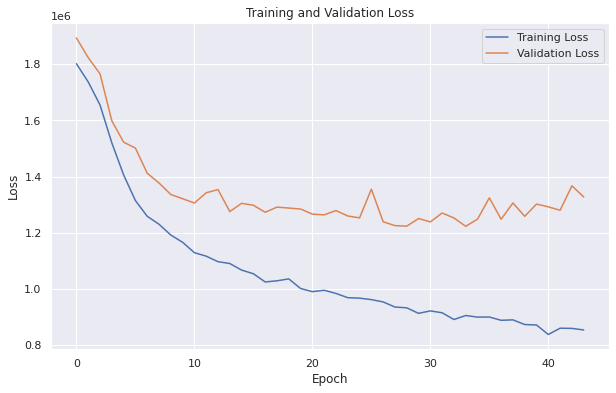

In [7]:
sns.set()
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
